# **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys, AllChem, DataStructs
from sklearn.preprocessing import StandardScaler
from tape import ProteinBertModel, TAPETokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

# **Exploratory Data Analysis**

In [2]:
df = pd.read_csv('../artifacts/data_ingestion/data/data.csv')

In [3]:
# Display the first few rows
print("\n🟢 ─── Data Preview (Head) ───")
print(df.head())

# Summary statistics
print("\n🟡 ─── Data Summary (Describe) ───")
print(df.describe(include='all').transpose())

# Dataframe info
print("\n🔵 ─── Data Info ───")
df.info()

# Shape of the dataframe
print("\n🟠 ─── Data Shape ───")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Column names
print("\n🟣 ─── Column Names ───")
print(", ".join(df.columns))

# Data types of columns
print("\n🔴 ─── Column Data Types ───")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col}: {dtype}")

# Count of missing values
print("\n🟡 ─── Missing Values ───")
missing = df.isnull().sum()
print(missing[missing > 0].to_string() if missing.sum() > 0 else "No missing values ✅")



🟢 ─── Data Preview (Head) ───
  molecule_chembl_id standard_type  standard_value standard_units  \
0       chembl113081          ic50        100000.0             nm   
1       chembl324340          ic50          2500.0             nm   
2       chembl324340          ic50         50000.0             nm   
3       chembl109600          ic50          9000.0             nm   
4       chembl357278          ic50          4000.0             nm   

  target_chembl_id                   pref_name  
0       chembl1806  dna topoisomerase ii alpha  
1       chembl3921                  heparanase  
2    chembl3879801          non-protein target  
3       chembl3921                  heparanase  
4       chembl4632       palmitoyl-coa oxidase  

🟡 ─── Data Summary (Describe) ───
                         count   unique           top      freq  \
molecule_chembl_id    10880154  1666658   chembl53463      6841   
standard_type         10880154        7       potency   4308761   
standard_value      1088

In [4]:
# check unique standard units and types

print("\n🟢 ─── Unique Standard Units ───")
print(df['standard_units'].unique())

print("\n🟢 ─── Unique Types ───")
print(df['standard_type'].unique())


🟢 ─── Unique Standard Units ───
['nm']

🟢 ─── Unique Types ───
['ic50' 'ec50' 'mic' 'ki' 'gi50' 'ac50' 'potency']


/home/sanskar-modi/miniconda3/envs/aidd/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


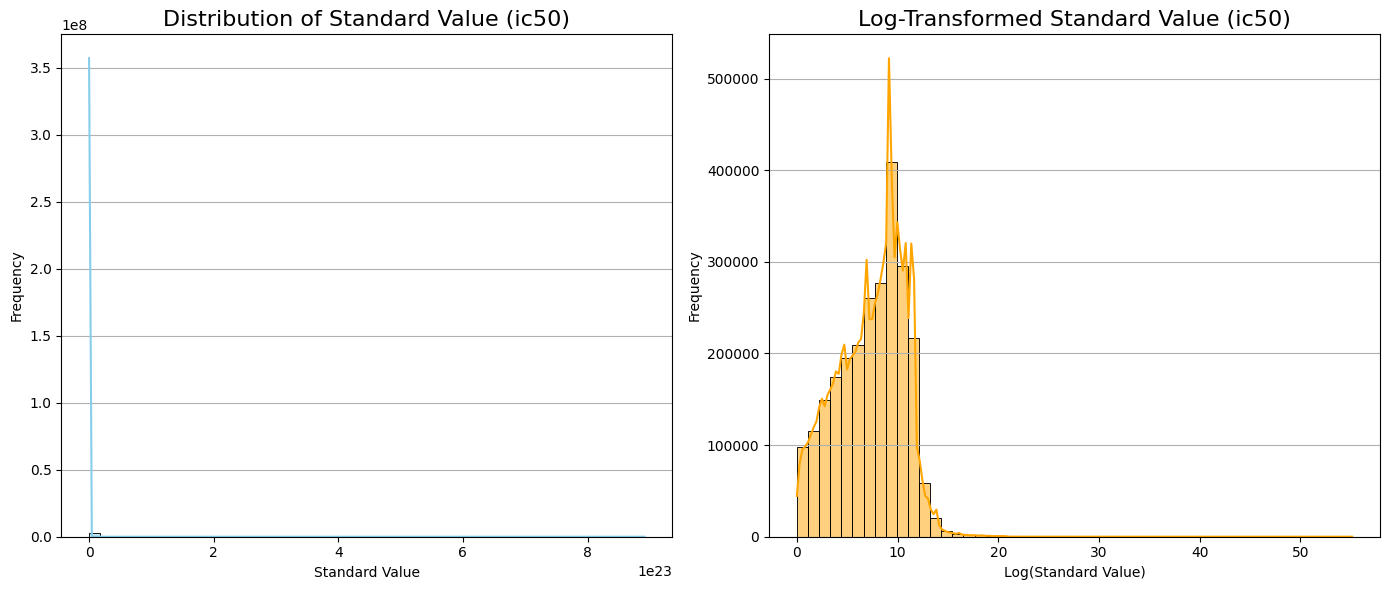

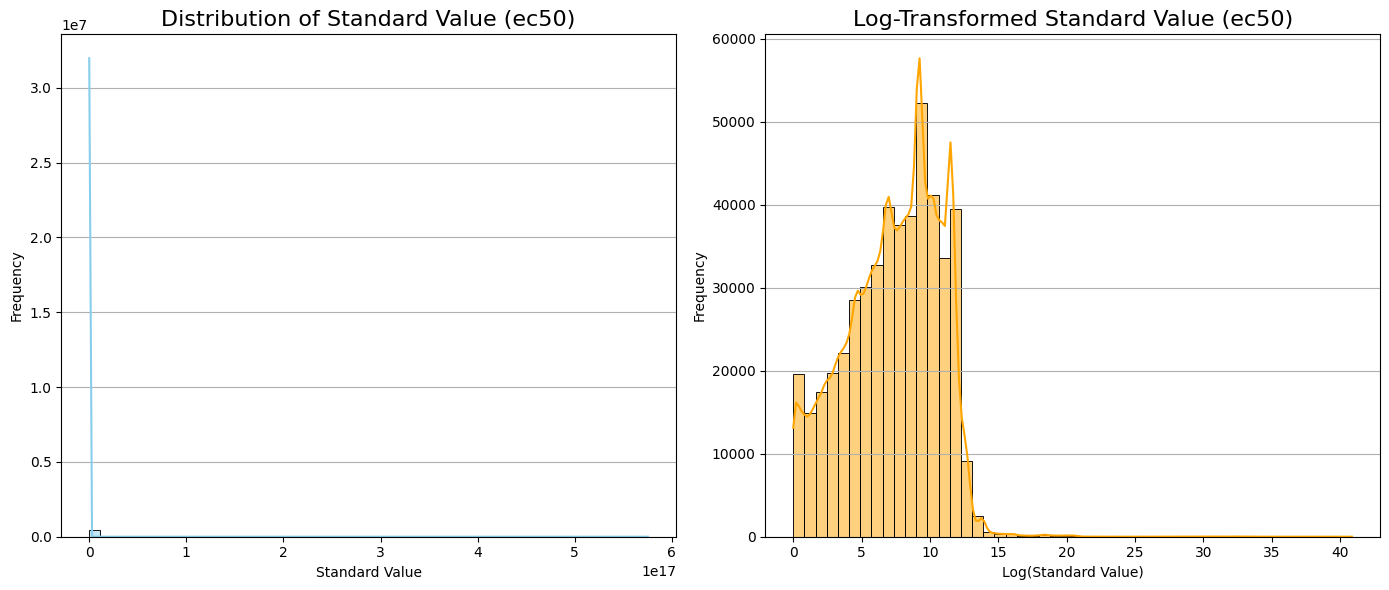

/home/sanskar-modi/miniconda3/envs/aidd/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


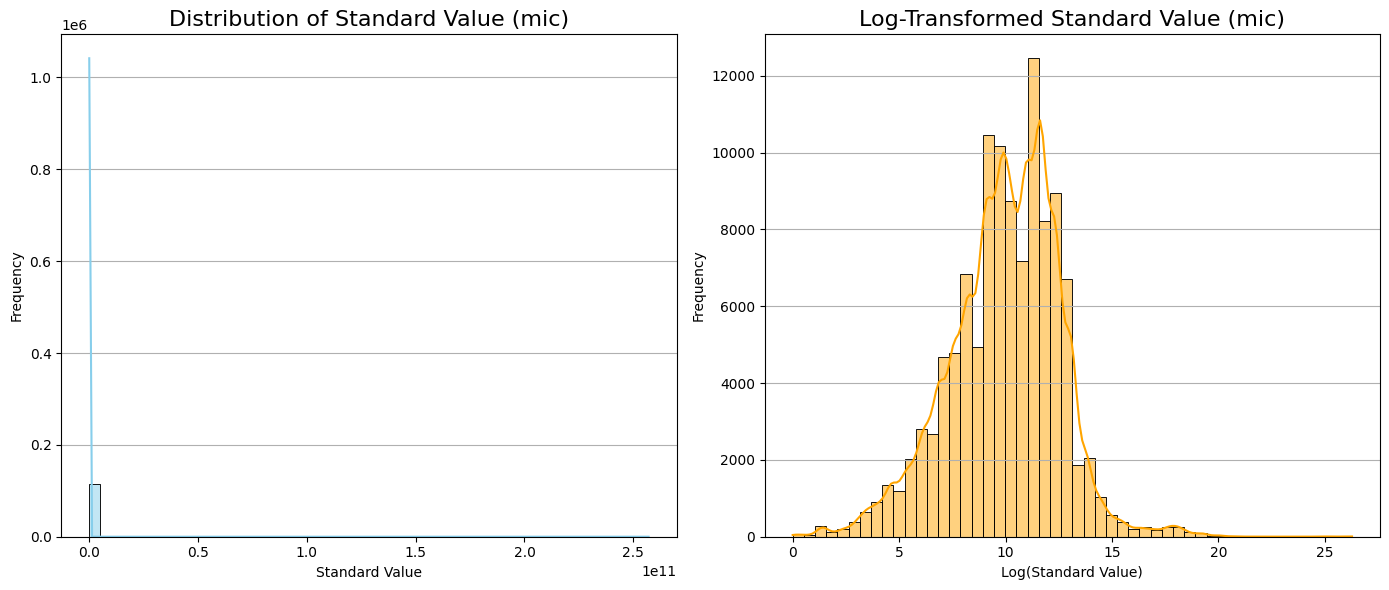

/home/sanskar-modi/miniconda3/envs/aidd/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sanskar-modi/miniconda3/envs/aidd/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


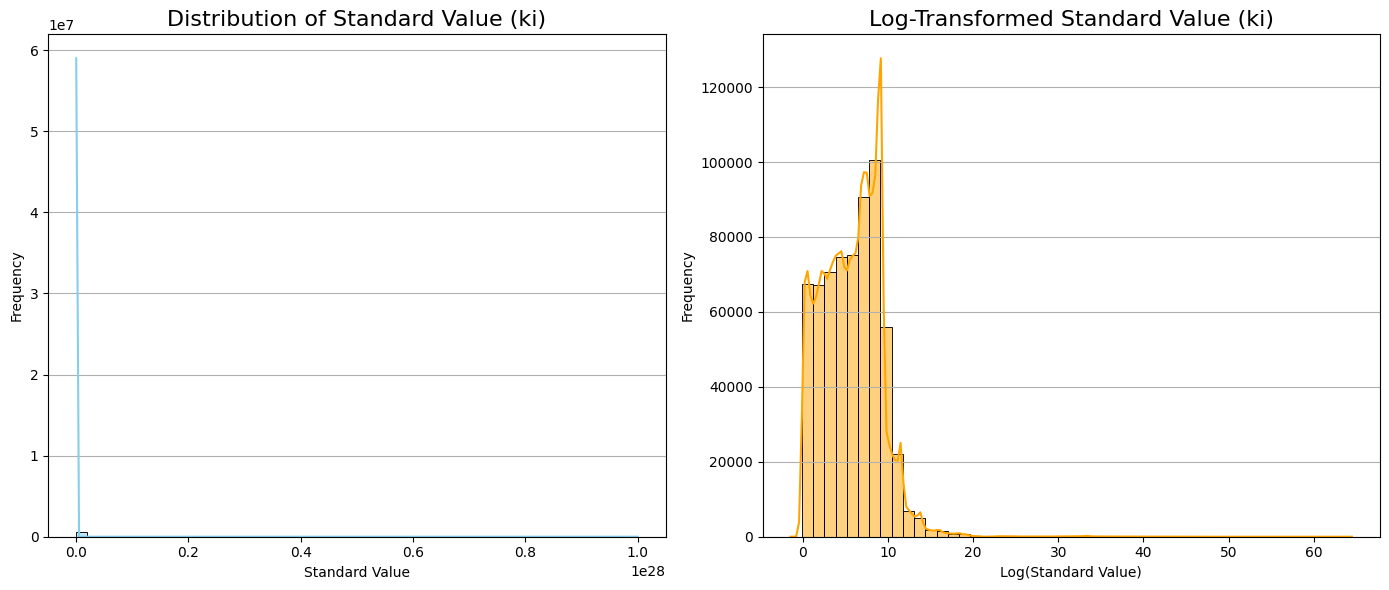

/home/sanskar-modi/miniconda3/envs/aidd/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


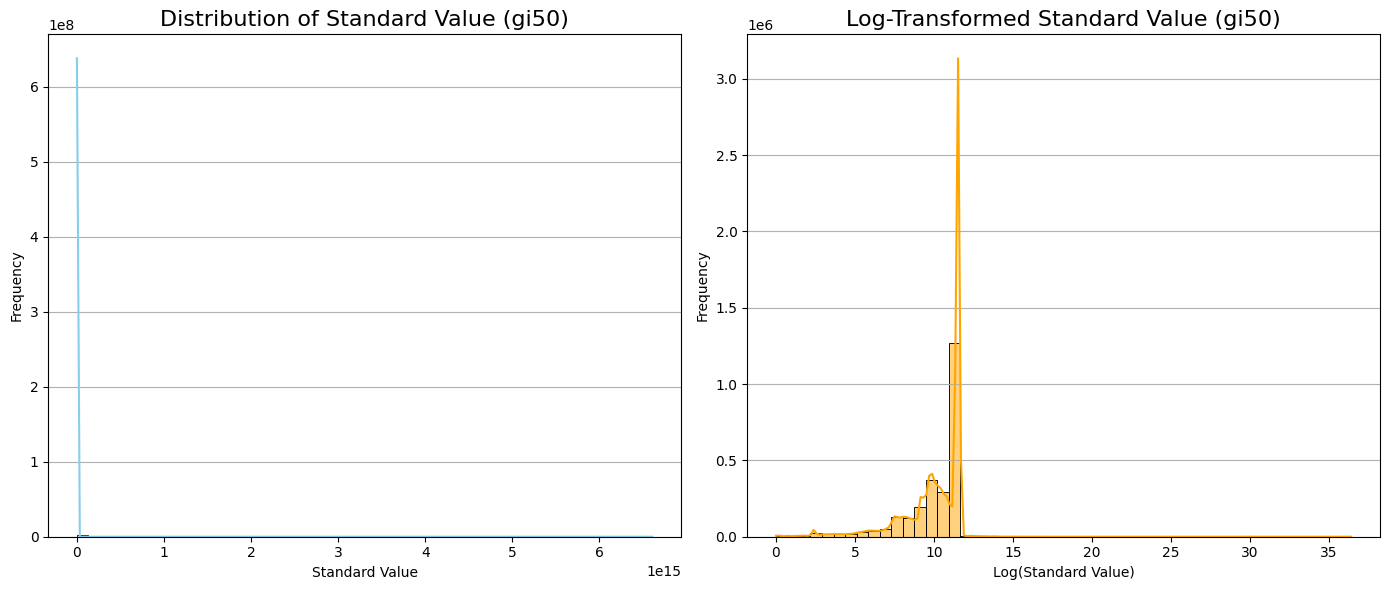

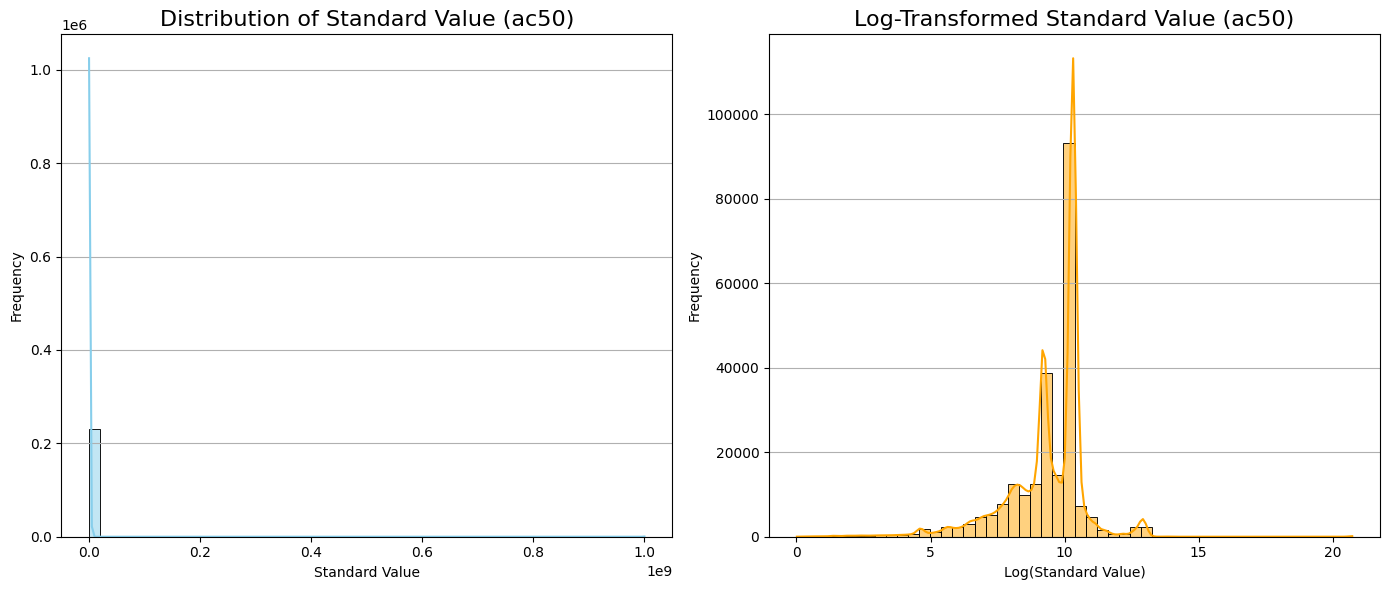

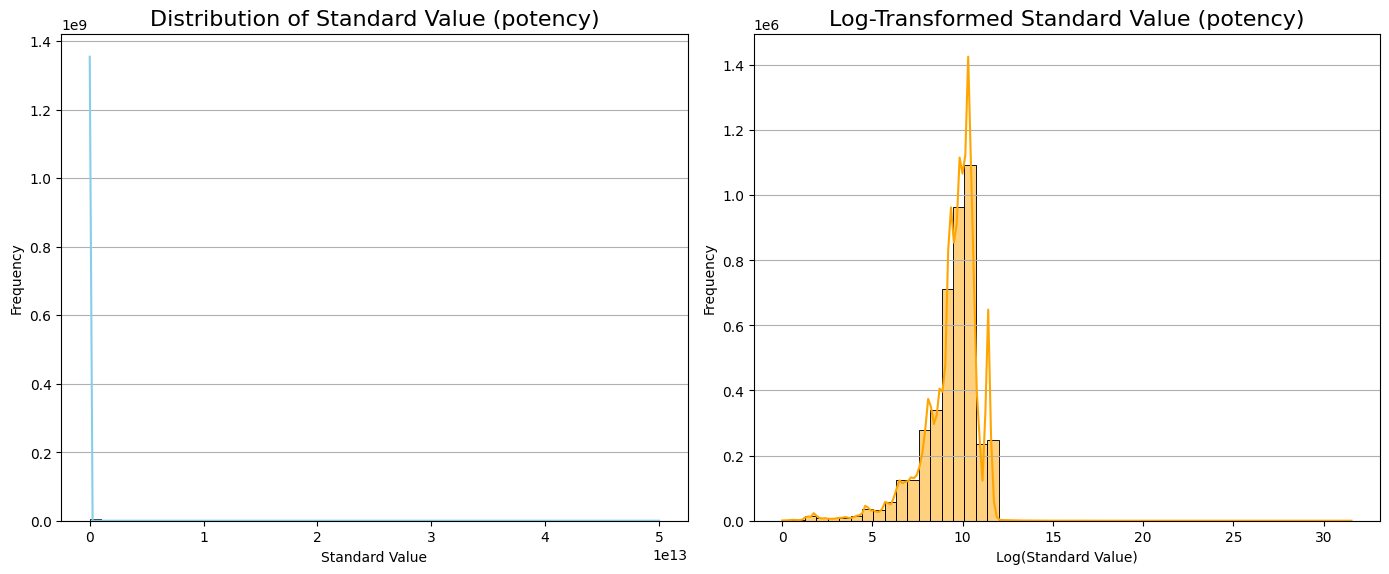

In [5]:
# distribution of standard values for each standard type

standard_types = df['standard_type'].unique()

for stype in standard_types:
    subset = df[df['standard_type'] == stype]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw Distribution
    sns.histplot(subset['standard_value'], bins=50, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Distribution of Standard Value ({stype})', fontsize=16)
    axes[0].set_xlabel('Standard Value')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y')

    # Log-Transformed Distribution
    sns.histplot(np.log1p(subset['standard_value']), bins=50, kde=True, color='orange', ax=axes[1])
    axes[1].set_title(f'Log-Transformed Standard Value ({stype})', fontsize=16)
    axes[1].set_xlabel('Log(Standard Value)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.show()


🟠 ─── Top 10 Frequent Molecules ───
molecule_chembl_id
chembl53463     6841
chembl98        4539
chembl428647    4039
chembl185       3471
chembl44657     2709
chembl20        2548
chembl76        2434
chembl67        2231
chembl65        2220
chembl1336      2165
Name: count, dtype: int64


/tmp/ipykernel_7582/3242109168.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_molecules.index, y=top_molecules.values, palette='viridis')


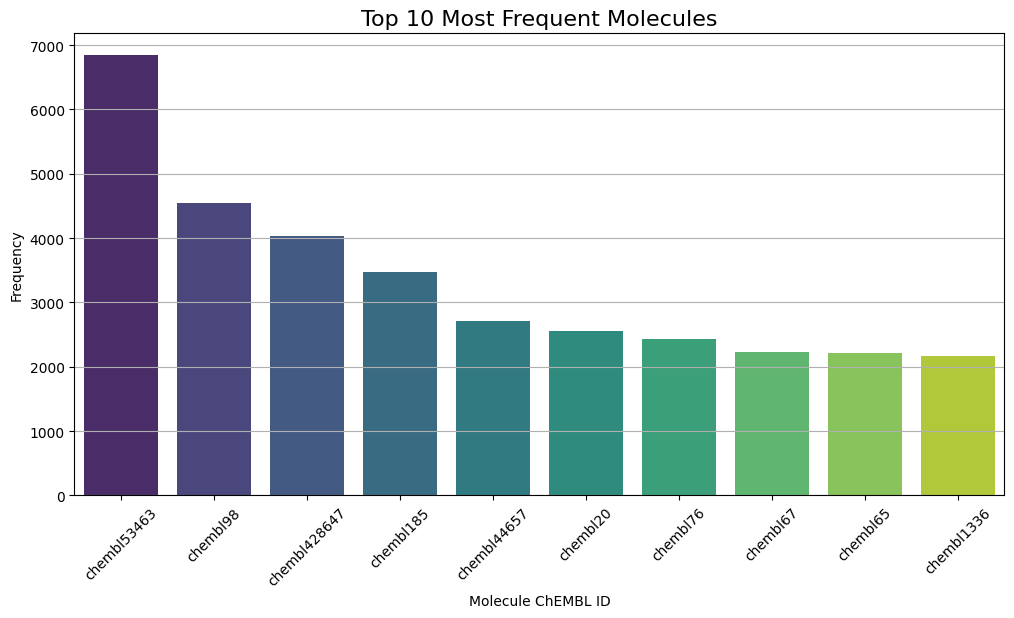

In [6]:
# Top 10 most frequent molecules

print("\n🟠 ─── Top 10 Frequent Molecules ───")
top_molecules = df['molecule_chembl_id'].value_counts().head(10)
print(top_molecules)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_molecules.index, y=top_molecules.values, palette='viridis')
plt.title('Top 10 Most Frequent Molecules', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Molecule ChEMBL ID')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


🟠 ─── Top 10 Frequent Targets ───
target_chembl_id
chembl612545     932494
chembl364        377434
chembl1075138    345078
chembl3879801    130751
chembl1293278    128009
chembl1741209    122559
chembl5391       116817
chembl1784       109333
chembl1293224     95115
chembl392         94214
Name: count, dtype: int64


/tmp/ipykernel_7582/1407837060.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_targets.index, y=top_targets.values, palette='plasma')


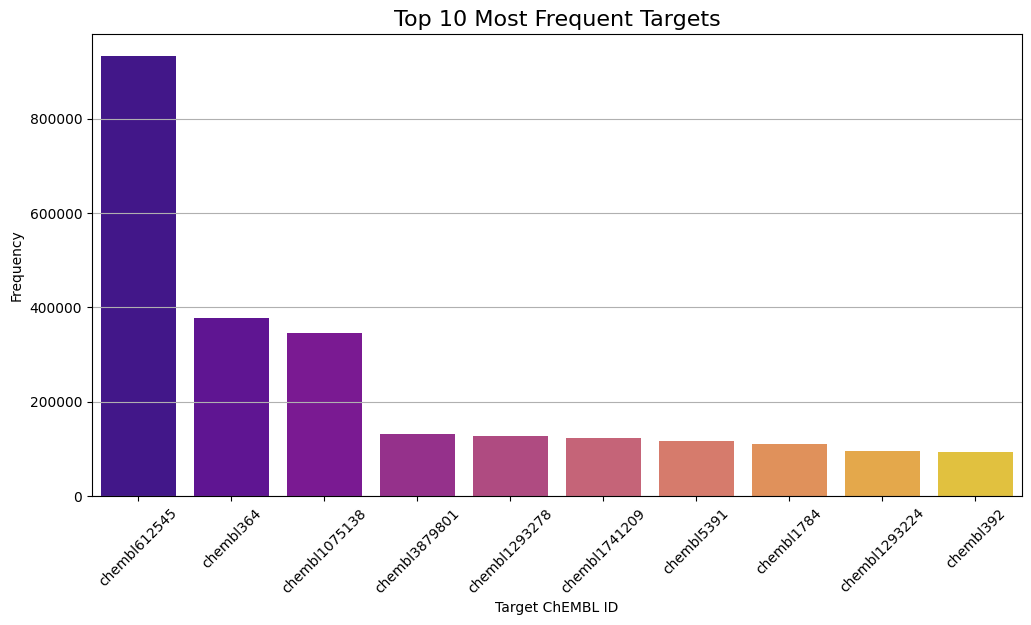

In [7]:
# Top 10 most frequent targets

print("\n🟠 ─── Top 10 Frequent Targets ───")
top_targets = df['target_chembl_id'].value_counts().head(10)
print(top_targets)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_targets.index, y=top_targets.values, palette='plasma')
plt.title('Top 10 Most Frequent Targets', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Target ChEMBL ID')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# **Feature Engineering**

In [8]:
# using a small subset of the data from now onwards (just for this notebook experimentation) for faster computation

df = df.sample(1000, random_state=42)
df.shape

(1000, 6)

In [9]:
# 🚀 Step 1: Convert ChEMBL IDs to SMILES (Molecules)
print("\n🔹 Converting ChEMBL IDs (Molecules) to SMILES...")

# Initialize ChEMBL client
molecule = new_client.molecule

# Function to get SMILES from ChEMBL ID
def get_smiles(chembl_id):
    """Fetch SMILES for molecules from ChEMBL ID"""
    try:
        res = molecule.get(chembl_id)
        if res and 'molecule_structures' in res and res['molecule_structures']:
            return res['molecule_structures']['canonical_smiles']
        return None
    except:
        return None

# Map molecule ChEMBL IDs to SMILES
tqdm.pandas()
df['mol_SMILES'] = df['molecule_chembl_id'].progress_apply(lambda x: get_smiles(x))


🔹 Converting ChEMBL IDs (Molecules) to SMILES...


100%|██████████| 1000/1000 [00:00<00:00, 1281.68it/s]


In [10]:
# 🚀 Step 2: Convert ChEMBL Target IDs to Sequences/Descriptions
print("\n🔹 Converting Target ChEMBL IDs to Sequences/Descriptions...")

# Initialize ChEMBL client for targets
target = new_client.target_component

# Function to get protein sequences or descriptions for targets
def get_target_info(chembl_id):
    """Fetch target info (protein sequence or description) from ChEMBL ID"""
    try:
        res = target.filter(target_chembl_id=chembl_id)
        if res:
            for item in res:
                if 'sequence' in item and item['sequence']:
                    return item['sequence']  # Return protein sequence if available
                elif 'description' in item:
                    return item['description']  # Fallback to description
        return None
    except Exception as e:
        print(f"Error fetching target info for {chembl_id}: {e}")
        return None

# Map target ChEMBL IDs to sequences/descriptions
tqdm.pandas()
df['target_info'] = df['target_chembl_id'].progress_apply(get_target_info)



🔹 Converting Target ChEMBL IDs to Sequences/Descriptions...


100%|██████████| 1000/1000 [00:03<00:00, 251.56it/s]


In [11]:
df.head()

,molecule_chembl_id,standard_type,standard_value,standard_units,target_chembl_id,pref_name,mol_SMILES,target_info
9189478,chembl3604471,ic50,177.0,nm,chembl394,hct-116,CC(N)c1csc(/C=N/Nc2ncnc3sc(C(C)(C)C)cc23)n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
4164007,chembl1327079,potency,2133.1,nm,chembl5567,luciferin 4-monooxygenase,Br.Cc1ccc(SCc2cn3c(C)csc3n2)cc1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
10713522,chembl1433,ac50,30000.0,nm,chembl259,melanocortin receptor 4,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
1813801,chembl1431679,potency,25929.0,nm,chembl612545,unchecked,Cc1cc(=O)oc2cc(NC(S)=NNC(=O)c3c(Cl)cnn3C)ccc12,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
10132157,chembl359744,ic50,670.0,nm,chembl395,hepg2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...


In [12]:
df.isnull().sum()

molecule_chembl_id    0
standard_type         0
standard_value        0
standard_units        0
target_chembl_id      0
pref_name             0
mol_SMILES            8
target_info           0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
# Converting SMILES & Target Sequences into Model-Ready Numerical Features

def smiles_to_fp(smiles, radius=2, n_bits=2048):
    """Convert SMILES to ECFP fingerprint with error handling"""
    if not smiles or pd.isna(smiles):  # Handle missing values
        return np.zeros(n_bits)
    
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:
        # Fallback to AllChem for compatibility
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        
        # Convert to numpy array
        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return np.zeros(n_bits)


def smiles_to_maccs(smiles):
    """Convert SMILES to MACCS keys with error handling"""
    if not smiles or pd.isna(smiles):  # Handle missing values
        return np.zeros(167)
    
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((167,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return np.zeros(167)  # MACCS keys have 167 bits

def smiles_to_descriptors(smiles):
    """Extract RDKit molecular descriptors with error handling"""
    if not smiles or pd.isna(smiles):  # Handle missing values
        return [0] * len(Descriptors.descList)
    
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:
        descriptors = [desc[0] for desc in Descriptors.descList]
        values = [Descriptors.__dict__[desc](mol) for desc in descriptors]
        return values
    else:
        return [0] * len(Descriptors.descList)

# ✅ Protein Embeddings
def get_protein_embedding(seq, model, tokenizer, device):
    """Convert protein sequence to TAPE embedding with error handling"""
    if not seq or pd.isna(seq):  # Handle missing protein sequences
        return np.zeros(768)  # Return zero vector if invalid sequence
    
    tokenized_seq = torch.tensor([tokenizer.encode(seq)]).to(device)
    
    with torch.no_grad():
        output = model(tokenized_seq)
        embedding = output[0].mean(dim=1).squeeze().cpu().numpy()

    return embedding

# ✅ Load TAPE model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinBertModel.from_pretrained('bert-base').to(device).eval()
tokenizer = TAPETokenizer(vocab='iupac')

# ✅ Apply Feature Extraction

# Molecular features (SMILES)
print("🚀 Extracting Molecular Features...")
mol_fp = np.stack([smiles_to_fp(sm) for sm in tqdm(df['mol_SMILES'], desc="ECFP Fingerprints")])
mol_maccs = np.stack([smiles_to_maccs(sm) for sm in tqdm(df['mol_SMILES'], desc="MACCS Keys")])
mol_desc = np.stack([smiles_to_descriptors(sm) for sm in tqdm(df['mol_SMILES'], desc="RDKit Descriptors")])

# Protein sequence embeddings
print("🚀 Extracting Protein Sequence Features...")
target_embeddings = np.stack([
    get_protein_embedding(seq, model, tokenizer, device)
    for seq in tqdm(df['target_info'], desc="Protein Embeddings")
])

# ✅ Convert features to DataFrames
mol_fp_df = pd.DataFrame(mol_fp, columns=[f"FP_{i}" for i in range(mol_fp.shape[1])])
mol_maccs_df = pd.DataFrame(mol_maccs, columns=[f"MACCS_{i}" for i in range(mol_maccs.shape[1])])
mol_desc_df = pd.DataFrame(mol_desc, columns=[f"DESC_{i}" for i in range(mol_desc.shape[1])])
target_emb_df = pd.DataFrame(target_embeddings, columns=[f"TARGET_EMB_{i}" for i in range(target_embeddings.shape[1])])

# ✅ Combine all features
features = pd.concat([mol_fp_df, mol_maccs_df, mol_desc_df, target_emb_df], axis=1)

# ✅ Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# ✅ Add labels
features_df = pd.DataFrame(features_normalized, columns=features.columns)
features_df['standard_value'] = df['standard_value'].values


🚀 Extracting Molecular Features...


ECFP Fingerprints:   0%|          | 0/992 [00:00<?, ?it/s][14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerator
[14:03:34] DEPRECATION WARNING: please use MorganGenerato

🚀 Extracting Protein Sequence Features...


Protein Embeddings:   0%|          | 0/992 [00:00<?, ?it/s]/tmp/ipykernel_7582/514426206.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  tokenized_seq = torch.tensor([tokenizer.encode(seq)]).to(device)
Protein Embeddings: 100%|██████████| 992/992 [00:27<00:00, 36.71it/s]


In [15]:
features_df.shape

(992, 3201)

In [16]:
df["mol_SMILES"].isnull().sum()

np.int64(0)

In [17]:
# creating final datasets for the model

features_df = features_df.reset_index(drop=True)
df = df.reset_index(drop=True)
final_df = features_df
final_df["mol_SMILES"] = df["mol_SMILES"]
final_df["target_info"] = df["target_info"]
final_df["standard_type"] = df["standard_type"]
final_df["standard_value"] = df["standard_value"]
final_df.dropna(inplace=True)
final_df.shape

(987, 3204)

In [18]:
# creating final datasets for the model

X = final_df.drop(["standard_type", "standard_value"], axis=1)
y = pd.get_dummies(final_df['standard_type']).mul(final_df['standard_value'], axis=0)

print("\n🟢 ─── Final Dataset (X) ───")
print(X.head())

print("\n🟢 ─── Final Dataset (y) ───")
print(y.head())


🟢 ─── Final Dataset (X) ───
   FP_0      FP_1      FP_2      FP_3      FP_4      FP_5      FP_6      FP_7  \
0   0.0  1.941451  4.088311 -0.084301 -0.135943 -0.170428 -0.063628 -0.055076   
1   0.0 -0.515079 -0.244600 -0.084301 -0.135943 -0.170428 -0.063628 -0.055076   
2   0.0 -0.515079 -0.244600 -0.084301 -0.135943 -0.170428 -0.063628 -0.055076   
3   0.0 -0.515079 -0.244600 -0.084301 -0.135943 -0.170428 -0.063628 -0.055076   
4   0.0 -0.515079 -0.244600 -0.084301 -0.135943 -0.170428 -0.063628 -0.055076   

       FP_8      FP_9  ...  TARGET_EMB_760  TARGET_EMB_761  TARGET_EMB_762  \
0 -0.176593 -0.123908  ...             0.0             0.0             0.0   
1 -0.176593 -0.123908  ...             0.0             0.0             0.0   
2 -0.176593 -0.123908  ...             0.0             0.0             0.0   
3 -0.176593 -0.123908  ...             0.0             0.0             0.0   
4 -0.176593 -0.123908  ...             0.0             0.0             0.0   

   TARGET_EMB_7

In [19]:
X.isnull().sum().any(), y.isnull().sum().any()

(np.False_, np.False_)

# **Model Training**